In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor

The NYC Taxi and Limousine commission describes the fare calculation as below.
<br>(1)The initial charge is $2.50.
<br>(2)Plus 50 cents per 1/5 mile or 50 cents per 60 seconds in slow traffic or when the vehicle is stopped.
I will use this information to perform some data cleaning and other analysis activity later.
<br><br>
Fistly, I load the data set and specify the column which needs to be parsed as date.

In [2]:
df_raw =  pd.read_csv('C:/Users/Shubham/Desktop/DSF/all/train.csv', nrows=100000, parse_dates=["pickup_datetime"])
df_raw.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

**Data Cleaning (1)** I Check if any row has null value for any of the columns.

In [3]:
df_raw.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

I will drop these incomplete records with null values.

In [4]:
print("Size before: %d" %len(df_raw))
df_raw = df_raw.dropna()
print("Size after: %d" %len(df_raw))

Size before: 100000
Size after: 100000


**Data Cleaning (2)** I Check if a row has the value zero for any of the columns.

In [5]:
df_raw[(df_raw['fare_amount'] == 0) | 
       (df_raw['pickup_datetime'] == 0) | (df_raw['pickup_longitude'] == 0) | 
       (df_raw['pickup_latitude'] == 0) | (df_raw['dropoff_longitude'] == 0) | 
       (df_raw['dropoff_latitude'] == 0) | (df_raw['passenger_count'] == 0)].count()

key                  2367
fare_amount          2367
pickup_datetime      2367
pickup_longitude     2367
pickup_latitude      2367
dropoff_longitude    2367
dropoff_latitude     2367
passenger_count      2367
dtype: int64

Several rows in the dataset have the value zero in atleast one columns.
I will drop these incomplete records.

In [6]:
print("Size before: %d" %len(df_raw))
df_raw = df_raw[(df_raw['fare_amount'] != 0) & 
       (df_raw['pickup_datetime'] != 0) & (df_raw['pickup_longitude'] != 0) & 
       (df_raw['pickup_latitude'] != 0) & (df_raw['dropoff_longitude'] != 0) & 
       (df_raw['dropoff_latitude'] != 0) & (df_raw['passenger_count'] != 0)]
print("Size after: %d" %len(df_raw))

Size before: 100000
Size after: 97633


Let us describe the data set and see if some more outliers can be noticed.

In [7]:
df_raw.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97633.000000,97633.000000,97633.000000,97633.000000,97633.000000,97633.000000
mean,11.352955,-73.918836,40.695586,-73.906725,40.695698,1.680876
std,9.699900,3.371528,2.784748,2.677138,2.788889,1.299125
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,1.000000
25%,6.000000,-73.992258,40.736592,-73.991390,40.735693,1.000000
50%,8.500000,-73.982065,40.753507,-73.980426,40.753943,1.000000
75%,12.500000,-73.968250,40.767668,-73.965067,40.768467,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


**Data Cleaning:**
    <br><br>(3) The fare_amount has some negative values, these must be incorrect.  drop them.
    <br>(4) Some coordinates are too much away from the coordinate limit of New York City.
    <br><br>I will define reasonable limits for Longitudes and Latitudes, removing all outliers beyond the limit.

In [8]:
print("Size before: %d" %len(df_raw))
df_raw = df_raw[(df_raw['fare_amount'] > 0)]
print("Size after: %d" %len(df_raw))

Size before: 97633
Size after: 97625


In order to remove outliers based on coordinates, I check if it is possible to define a limit based on our test data.

In [9]:
df_test =  pd.read_csv('C:/Users/Shubham/Desktop/DSF/all/test.csv', parse_dates=["pickup_datetime"])
df_test.dtypes

key                          object
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [10]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


The longititude and latitude column seem to be reasonably within the range of New York City.
I will define a limit for coordinates of our training data based on above tabel
and remove any records that do not confirm with this range.

In [11]:
#Range of coordinates
minimum_longitude = -74.263242
maximum_longitude = -72.986532
minimum_latitude = 40.568973
maximum_latitude = 41.709555

print("Size before: %d" %len(df_raw))
df_raw = df_raw[(df_raw.pickup_longitude >= minimum_longitude) & (df_raw.pickup_longitude <= maximum_longitude) &
           (df_raw.pickup_latitude >= minimum_latitude) & (df_raw.pickup_latitude <= maximum_latitude) &
           (df_raw.dropoff_longitude >= minimum_longitude) & (df_raw.dropoff_longitude <= maximum_longitude) &
           (df_raw.dropoff_latitude >= minimum_latitude) & (df_raw.dropoff_latitude <= maximum_latitude)]
print("Size after: %d" %len(df_raw))

Size before: 97625
Size after: 97479


**Data Cleaning :** 
(5) As per the official site of New York Taxi and Limousine Commision,
the maximum number of passengers allowed in a cab is 5, with an exception to allow one extra child passenger.
(Source-http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml)
    I am going to drop any rides which involved more than 6 passengers.

In [12]:
print("Size before: %d" %len(df_raw))
df_raw = df_raw[(df_raw.passenger_count <= 6)]
print("Size after: %d" %len(df_raw))

Size before: 97479
Size after: 97479


In [13]:
#In order to calculate euclidean distance between our coordinates, I am going to define a function
#This Function will take the GPS coordinates, convert them to UTM coordinates using PyPi library
#The UTM coordinates will be used to calculate euclidean distance using SciPy library.
#I have referenced the following threads for this part
#https://gis.stackexchange.com/questions/58530/find-euclidean-distance-in-gps
#https://math.stackexchange.com/questions/738529/distance-between-two-points-in-utm-coordinates

import utm
from scipy.spatial import distance

def euclidean_distance(row):
    utm1 = utm.from_latlon(row.pickup_latitude, row.pickup_longitude)
    utm2 = utm.from_latlon(row.dropoff_latitude, row.dropoff_longitude)
    distance_meters = distance.euclidean((utm1[0], utm1[1]),(utm2[0], utm2[1]))
    distance_miles = (distance_meters/1000)*0.621371
    return distance_miles

In [14]:
#Creating a new column that contains euclidean distance for rides
df_raw['euclidean_distance'] = df_raw.apply(euclidean_distance, axis=1)

In [15]:
#Creating a new column that contains hour of day of the pickup for rides
df_raw['pickup_hour'] = df_raw.pickup_datetime.apply(lambda t: t.hour)

In [16]:
#Creating a new column that contains hour of day of the pickup for rides
df_raw['pickup_day'] = df_raw.pickup_datetime.apply(lambda t: t.weekday())

**Task 2** (a) Pearson Correlation between Euclidean distance of the ride and the taxi fare.

In [17]:
df_raw['euclidean_distance'].corr(df_raw['fare_amount'])

0.8029763618387057

**Task 2** (b) Pearson Correlation between time of day and distance traveled.

In [18]:
df_raw['pickup_hour'].corr(df_raw['euclidean_distance'])

-0.030027235771374845

**Task 2** (c) Pearson Correlation between time of day and the taxi fare.

In [19]:
df_raw['pickup_hour'].corr(df_raw['fare_amount'])

-0.018571032033882048

The Euclidean distance and taxi fare show highest correlation amongst all the three pairs. There is a very strong correlation between distance and fare, which makes sense as we know that distance is one of the factors used in fare calculation. On the other hand, time of day does not seem to be correlated either with distance traveled or with taxi fare, at least at this point.

**Task 3** (a) Plot between Euclidean distance of the ride and the taxi fare.

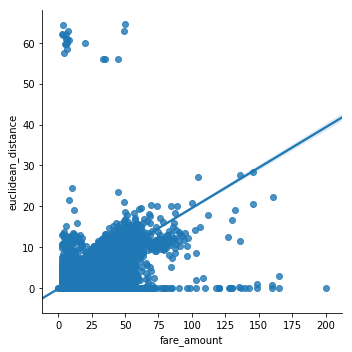

In [20]:
sns.lmplot(x='fare_amount', y='euclidean_distance', data=df_raw)

A linear relationship can be seen in the plot above for most of the data. There seem to be some outliers such as trips of zero distance but very high fares and trips of very long distances with zero fare. These trips are justifiable by some logics such as trips starting and ending at same points, but such trip details won't help our model. So I am going to drop them later. 

**Task 3** (b) Plot between time of day and distance traveled.

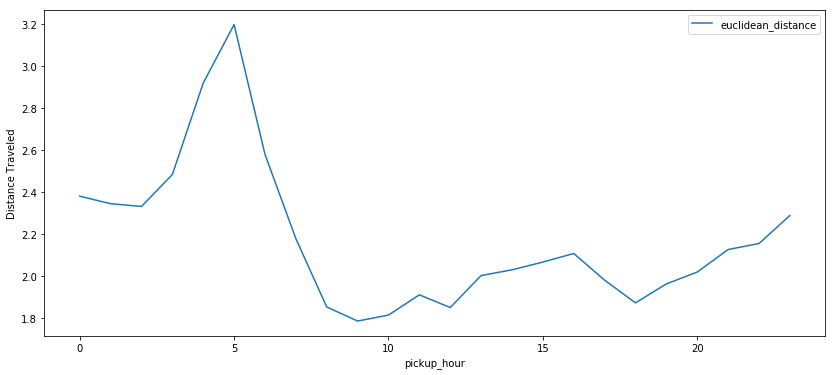

In [21]:
df_raw.pivot_table('euclidean_distance', index='pickup_hour').plot(figsize=(14,6))
matplotlib.pyplot.ylabel('Distance Traveled');

No useful relationship could be seen in the above plot, which was expected given the small correlation between the two 

**Task 3** (c) Plot between time of day and the taxi fare.

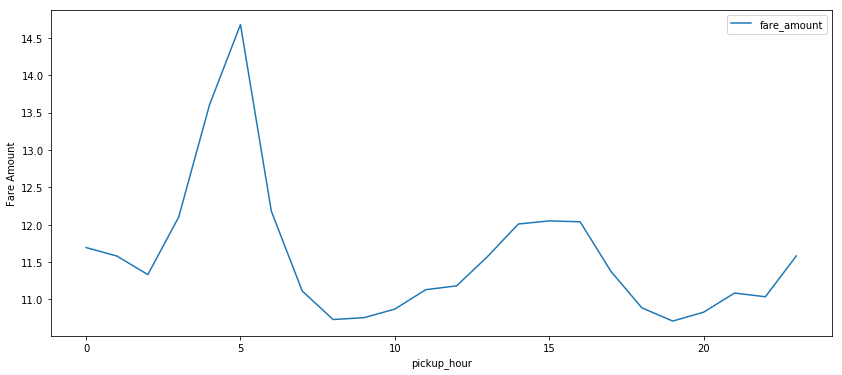

In [22]:
df_raw.pivot_table('fare_amount', index='pickup_hour').plot(figsize=(14,6))
matplotlib.pyplot.ylabel('Fare Amount');

Again, no useful relationship could be seen in the plot at this point.

Looking at the correlation table for our data, we see that there no other strong correlations.

In [23]:
df_raw.corr(method='pearson')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,pickup_hour,pickup_day
fare_amount,1.000000,0.392661,-0.178927,0.314397,-0.149553,0.015129,0.802976,-0.018571,0.000469
pickup_longitude,0.392661,1.000000,0.142855,0.391045,0.136672,0.000226,0.436397,0.021609,-0.026959
pickup_latitude,-0.178927,0.142855,1.000000,0.154392,0.472296,-0.003093,-0.123660,0.027745,-0.038696
dropoff_longitude,0.314397,0.391045,0.154392,1.000000,0.233330,-0.003693,0.343204,-0.038361,-0.006548
dropoff_latitude,-0.149553,0.136672,0.472296,0.233330,1.000000,-0.003697,-0.110119,0.017224,-0.025072
passenger_count,0.015129,0.000226,-0.003093,-0.003693,-0.003697,1.000000,0.011933,0.016336,0.036837
euclidean_distance,0.802976,0.436397,-0.123660,0.343204,-0.110119,0.011933,1.000000,-0.030027,0.011847
pickup_hour,-0.018571,0.021609,0.027745,-0.038361,0.017224,0.016336,-0.030027,1.000000,-0.087166
pickup_day,0.000469,-0.026959,-0.038696,-0.006548,-0.025072,0.036837,0.011847,-0.087166,1.000000


**Data Cleaning** Let's drop the outliers that we saw in Task 3 plot (a)

In [24]:
#Dropping trips with zero euclidean distance
print("Size before: %d" %len(df_raw))
df_raw = df_raw[(df_raw.euclidean_distance > 0)]
print("Size after: %d" %len(df_raw))

Size before: 97479
Size after: 96412


We know that the taxi meter starts with an initial charge of 2.5<span>$</span> and adds 50 cents for each 1/5 mile. By that logic a 25 mile trip will cost atleast 65<span>$</span>. But these are the present rates. The data we have is old, so we have to factor that as well. Interestingly, the rates haven't changed many times.There is was a good 7 years gap between the hike in 2005 and 2012. We don't have data before 2005. To be on the safe side we will consider rates before 2012. Before 2012 the taxi meter started with an initial charge of 2<span>$</span> and added 30 cents for each 1/5 mile. By that logic a 25 mile trip will cost atleast 39.5<span>$</span>.I am going to drop any trip longer than 25 miles with a fare less than 39.5<span>$</span>. Also every trip has to be of atleast 2<span>$</span>, if not I drop them as well.

In [25]:
#Dropping trips with fare below 2$
print("Size before: %d" %len(df_raw))
df_raw = df_raw[(df_raw.fare_amount >= 2)]
print("Size after: %d" %len(df_raw))

Size before: 96412
Size after: 96410


In [26]:
#Dropping trips longer than 25 miles with a fare less than 39.5$
print("Size before: %d" %len(df_raw))
df_raw = df_raw.drop(df_raw[(df_raw.euclidean_distance >=25) & (df_raw.fare_amount <= 39.5)].index)
print("Size after: %d" %len(df_raw))

Size before: 96410
Size after: 96394


**Task (4) & (5)** Let us create some new features from the existing data and see if any of these can be useful for our model.

In [27]:
#Creating a new column that contains year of the pickup for rides
df_raw['pickup_year'] = df_raw.pickup_datetime.apply(lambda t: t.year)

As mentioned already the taxi rates have increased sometimes over the years. So it will make sense if the year of the trip becomes one of the features of our model.

In [28]:
#Creating a new column that contains fare per mile for rides
df_raw['fare_per_mile'] = df_raw.fare_amount / df_raw.euclidean_distance

Let us plot the per mile fares against hours of a day, for each year in our data set.

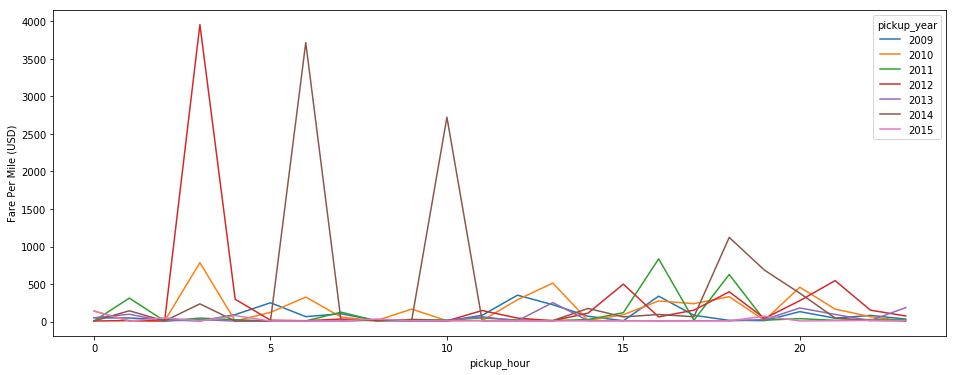

In [29]:
df_raw.pivot_table('fare_per_mile', index='pickup_hour', columns='pickup_year').plot(figsize=(16,6))
matplotlib.pyplot.ylabel('Fare Per Mile (USD)');

The plot reveals that some trips have unrealistic per mile rates. This may have been caused due to the trips which are less than 1 mile.
Let us set those trip aside for a while.

In [30]:
#Dropping trips shorter than one mile$
print("Size before: %d" %len(df_raw))
df_for_plotting = df_raw[(df_raw.euclidean_distance > 1)]
print("Size after: %d" %len(df_for_plotting))

Size before: 96394
Size after: 62488


Let us plot again with this new data set.

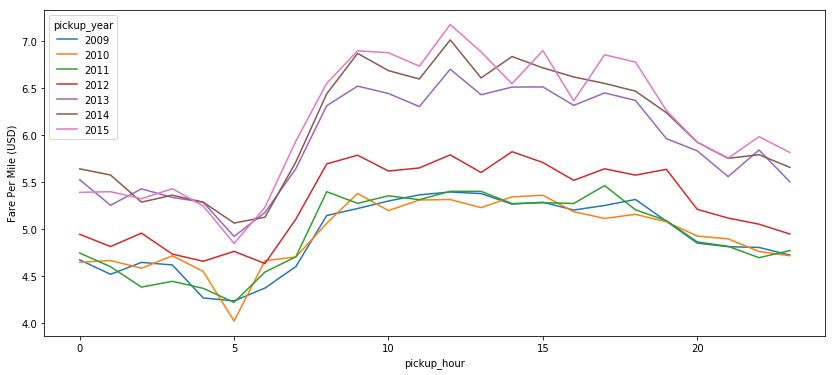

In [31]:
df_for_plotting.pivot_table('fare_per_mile', index='pickup_hour', columns='pickup_year').plot(figsize=(14,6))
matplotlib.pyplot.ylabel('Fare Per Mile (USD)');

As we can see, there are 3 noticeable group of lines. Each group indicates the years through which the taxi rates might have been the same. Thus depending on the year, different rates apply for trips. So year is going to be one of the feature of our model.

**Task (6)** Now let us create a simple linear regression model using our two features, eulicdean_distance and pickup_year.

Defining features of our model.

In [33]:
lr = LinearRegression()
matrix = np.matrix(df_raw)
X = df_raw[['euclidean_distance', 'pickup_year']].values;
y = df_raw['fare_amount'].values;

X.shape, y.shape

((96394, 2), (96394,))

Let us split the training data and generate the model. Also print the coeficients and intercept.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = lr.fit(X_train, y_train)
model.coef_, model.intercept_

(array([3.62012333, 0.51515227]), -1032.5826956524668)

Finding the RMSE of our model.

In [35]:
y_pred = model.predict(X_test)
print('Below is the RMSE for Linear model')
sqrt(mean_squared_error(y_test, y_pred))

Below is the RMSE for Linear model


4.635143930541522

In [36]:
model = lr.fit(X, y)
print('Below are the coeficients for Linear model')
model.coef_, model.intercept_

Below are the coeficients for Linear model


(array([3.65013395, 0.51449788]), -1031.316761562315)

Preparing our test data.

In [38]:
#I have preprocessed the test data and generated the trip distance values using google distance matrix api.
df_test =  pd.read_csv('C:/Users/Shubham/Desktop/test_google.csv', parse_dates=["pickup_datetime"])

In [39]:
#Creating a new column that contains euclidean distance for rides
df_test['euclidean_distance'] = df_test.apply(euclidean_distance, axis=1)

#Creating a new column that contains year of the pickup for rides
df_test['pickup_year'] = df_test.pickup_datetime.apply(lambda t: t.year)

In [40]:
matrix = np.matrix(df_raw)
X = df_test[['euclidean_distance', 'pickup_year']].values;

y_pred = model.predict(X)

Saving the output.

In [41]:
y_pred = model.predict(X)
output = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred},
    columns = ['key', 'fare_amount'])
output.to_csv('C:/Users/Shubham/Desktop/submission_linear_3M.csv', index = False)

**Task 7** There are several data sets available on the internet related to the New York Taxi. Below is the list of some of them.
    <br>(1) 2017 Yellow Taxi Trip Data - Source: NYC Open data, This dataset includes trip records from all trips completed in yellow taxis from in NYC during 2017.
    <br>(2) Hourly weather data for the New York City Taxi Trip Duration Challenge - Source:Kaggle
    <br>(3) Google's Distance Matrix API for "New York City Taxi Trip Duration" challenge - Source: Kaggle
<br><br>I am going to use an external data set. It is not entirely external. I created a data set using 10k rows from the training data and called the Google matrix api for these rows. Then I used this new data set to build a model which predicts trip duration for larger data set (training data set with 3M rows) 

In [42]:
#Loading the external data set
df_google =pd.read_csv('C:/Users/Shubham/Desktop/train_google2.csv', parse_dates=["pickup_datetime"])
df_google.dtypes

key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
euclidean_distance           float64
pickup_hour                    int64
pickup_year                    int64
fare_per_mile                float64
google_distance              float64
google_time                  float64
dtype: object

Building Random Forest Regressive model using the google data set.

In [43]:
matrix = np.matrix(df_google)
X = df_google[['pickup_longitude', 'pickup_latitude', 'euclidean_distance']]
y = df_google.google_time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)
error = sqrt(mean_squared_error(y_test,pred))
print('Below is the RMSE for Random Forest model for predicting trip time')
error

Below is the RMSE for Random Forest model for predicting trip time


3.2852258973097417

Let us train our model for entire data set and predict values.

In [44]:
rfr.fit(X, y)
matrix = np.matrix(df_raw)
X = df_raw[['pickup_longitude', 'pickup_latitude', 'euclidean_distance']]

df_raw['estimated_google_time'] = rfr.predict(X)

**Task 8** Now let us build another Random Forest Regressive model for predicting the taxi fare with one more feature that we just created.

In [54]:
matrix = np.matrix(df_raw)
X = df_raw[['euclidean_distance', 'pickup_year', 'estimated_google_time']]
y = df_raw.fare_amount

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Let us use the model to predict values.

In [56]:
matrix = np.matrix(df_test)
X = df_test[['euclidean_distance', 'pickup_year', 'google_time']]

y_pred = rfr.predict(X)

Finally we output the submission file containing fare amounts for the corresponding trips.

In [57]:
submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': y_pred},
    columns = ['key', 'fare_amount'])
submission.to_csv('C:/Users/Shubham/Desktop/submission_randomforest_estimatedtime1.csv', index = False)